In [4]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

Using matplotlib backend: TkAgg


In [75]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0, spore=3.256e6, macrophage=1e6):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        #S_ = gillespy2.Species(name='S_', initial_value=3.256e6) # low = 4e3; mid = 2e4; high = 1e7
        S_ = gillespy2.Species(name='S_', initial_value=spore) # low = 4e3; mid = 2e4; high = 1e7
        
        #A_ = gillespy2.Species(name='A_', initial_value=1e6) # A = Sa/(k2*S+MuA)
        A_ = gillespy2.Species(name='A_', initial_value=macrophage) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        self.add_species([S_,A_,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6])
        
        # parameters        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e6)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.0009)
        
        self.add_parameter([k2,k3])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:1, A_:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S_:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S_:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S_:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S_:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S_:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        # To the lung
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12])
        t = numpy.linspace(0,10,201)
        self.timespan(t)
        #print(t)

In [76]:
#model = DayModel()

In [77]:
#%time results = model.run(solver=SSACSolver, seed=123)
#%time results = model.run(solver=BasicODESolver)

results = []

for i in numpy.arange(3e6, 5e6, 10000):
    model = DayModel(spore=i, macrophage=1e6)
    %time results.extend(model.run(solver=BasicODESolver)) 

CPU times: user 78.1 ms, sys: 31.2 ms, total: 109 ms
Wall time: 76.2 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 70.7 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 77.1 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 80.2 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 70.6 ms
CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 71.9 ms
CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 73.7 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 76.6 ms
CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 71.9 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 76 ms
CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 82 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 73.7 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 76.9 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 84.7 ms
CPU times: user 78.1 m

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 91.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 81.3 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 76.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 79.6 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 78.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 78.1 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 78.1 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 75.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 74.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 75.5 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 75.3 ms
CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 73 ms
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 81.8 ms
CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 89.5 ms
CPU times: user 78.1 m

In [78]:
print(len(results))

200


In [79]:
from scipy import stats
res = results[0]
data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

means = []

for i in range(0, 199):
    data3 = []
    res = results[i]
    data3.extend([1]*int(res['HLN1'][-1]))
    data3.extend([2]*int(res['HLN2'][-1]))
    data3.extend([3]*int(res['HLN3'][-1]))
    data3.extend([4]*int(res['HLN4'][-1]))
    data3.extend([5]*int(res['HLN5'][-1]))
    data3.extend([6]*int(res['HLN6'][-1]))
    mean = numpy.mean(data3)
    sd = numpy.std(data3)
    sem = stats.sem(data3)
    means.append(mean)
print(results[0])

{'time': [0.0, 0.049999999999998934, 0.09999999999999787, 0.1499999999999968, 0.19999999999999574, 0.24999999999999467, 0.2999999999999936, 0.34999999999999254, 0.3999999999999915, 0.4499999999999904, 0.49999999999998934, 0.5499999999999883, 0.5999999999999872, 0.6499999999999861, 0.6999999999999851, 0.749999999999984, 0.799999999999983, 0.8499999999999819, 0.8999999999999808, 0.9499999999999797, 0.9999999999999787, 1.0499999999999776, 1.0999999999999766, 1.1499999999999755, 1.1999999999999744, 1.2499999999999734, 1.2999999999999723, 1.3499999999999712, 1.3999999999999702, 1.449999999999969, 1.499999999999968, 1.549999999999967, 1.599999999999966, 1.6499999999999648, 1.6999999999999638, 1.7499999999999627, 1.7999999999999616, 1.8499999999999606, 1.8999999999999595, 1.9499999999999584, 1.9999999999999574, 2.0499999999999563, 2.0999999999999552, 2.149999999999954, 2.199999999999953, 2.249999999999952, 2.299999999999951, 2.34999999999995, 2.399999999999949, 2.4499999999999478, 2.499999999

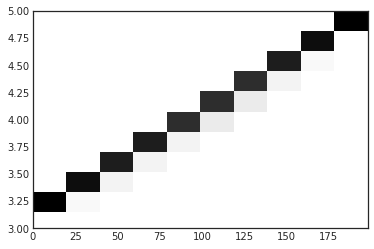

In [80]:
plt.hist2d(range(0, 199), means)
plt.ylim(3, 5)
plt.show()

#n,x2,_ = plt.hist(data3,bins=6,edgecolor='black')
#bin_centers = 0.5*(x2[1:]+x2[:-1])
#plt.plot(bin_centers, n)
#plt.show()

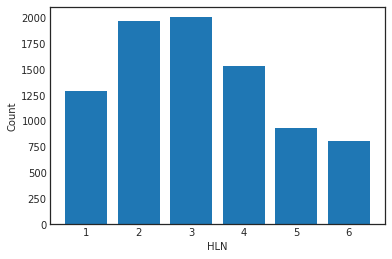

Mean: 	4.994849400962938
STD:  	1.325011670024823
SEM:  	0.014021483778739092


In [81]:
plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

print("Mean: \t{}".format(mean))
print("STD:  \t{}".format(sd))
print("SEM:  \t{}".format(sem))

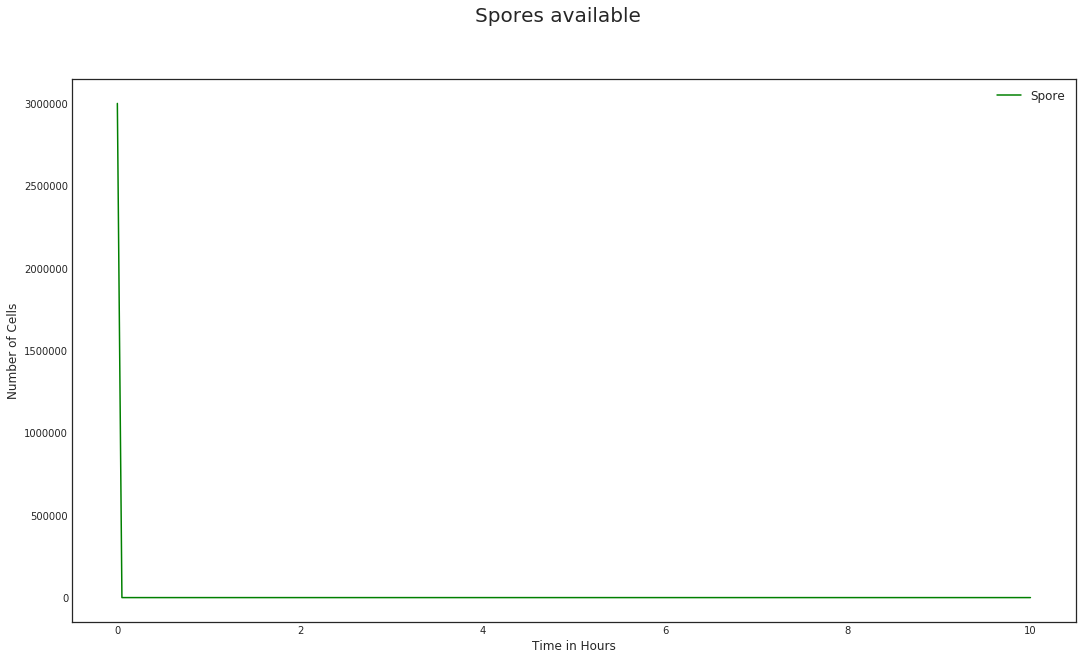

In [82]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
# print("Initial spores: {}".format(results['S_'][0]))
# print("Spores remaining: {}".format(results['S_'][-1]))
# print("Spores at 5 hours: {}".format(results['S_'][100]))


Lung Hosts at end:
H1: 142620.2895271538
H2: 217889.49623042686
H3: 221921.82867109633
H4: 169521.58893990482
H5: 103595.28566715408
H6: 88815.5973799324


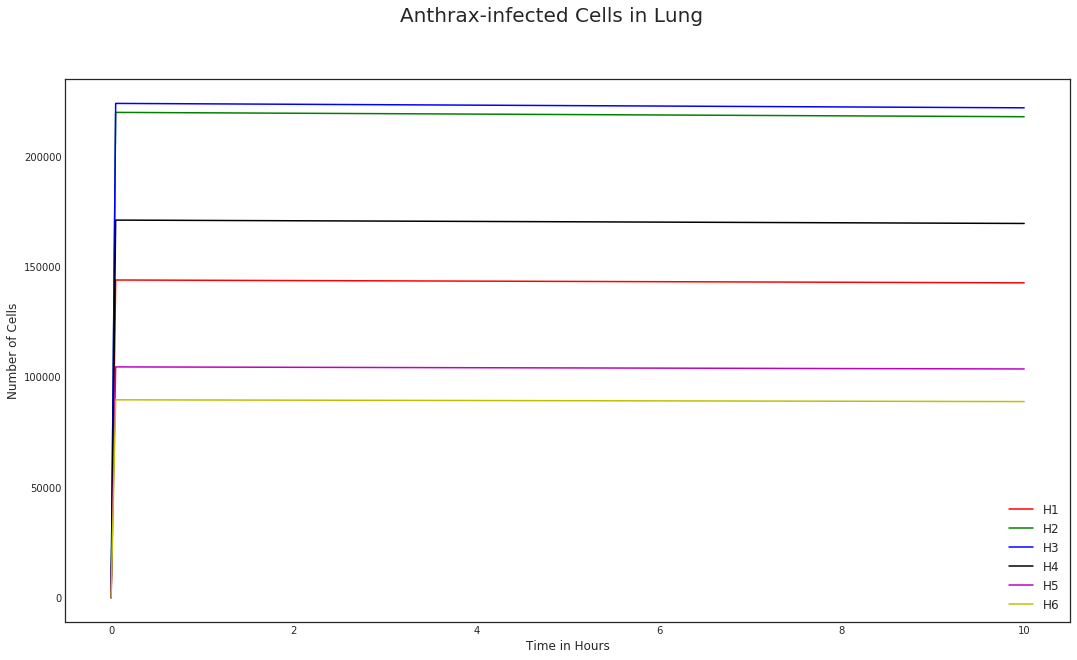

In [83]:
res = results[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))




k2 = 1.00e+06, k3 = 9.00e-04
Lung Hosts at end:
H1: 142620.2895271538
H2: 217889.49623042686
H3: 221921.82867109633
H4: 169521.58893990482
H5: 103595.28566715408
H6: 88815.5973799324
Lymph Node Hosts at end:
HLN1: 1289.3760921056364
HLN2: 1969.856519656768
HLN3: 2006.311312040315
HLN4: 1532.5805647953243
HLN5: 936.5657932464092
HLN6: 802.9482217949999


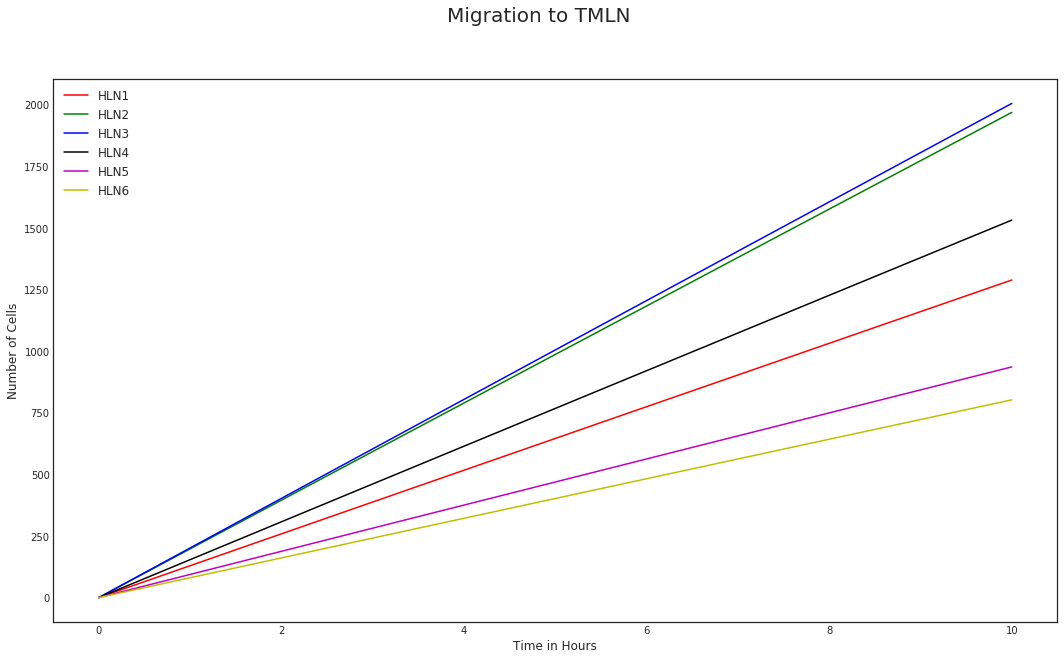

In [84]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
res = results[0]

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model.listOfParameters['k2'].expression), float(model.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(res['HLN1'][-1]))
print("HLN2: {}".format(res['HLN2'][-1]))
print("HLN3: {}".format(res['HLN3'][-1]))
print("HLN4: {}".format(res['HLN4'][-1]))
print("HLN5: {}".format(res['HLN5'][-1]))
print("HLN6: {}".format(res['HLN6'][-1]))